In [1]:
# ALWAYS RUN THIS FIRST!
import os
import sys
from pathlib import Path

NOTEBOOK_DIR = Path("/rsrch5/home/plm/yshokrollahi/MOE-VITP/vitamin-p-simple_July17th/notebooks/vitaminp")
os.chdir(NOTEBOOK_DIR)
sys.path.insert(0, str(NOTEBOOK_DIR))

print(f"✅ Working directory: {os.getcwd()}")

✅ Working directory: /rsrch5/home/plm/yshokrollahi/MOE-VITP/vitamin-p-simple_July17th/notebooks/vitaminp


## Load Dataset

In [2]:
# Cell 3: Import and create dataloaders
from crc_dataset import Config, create_dataloaders

config = Config("config.yaml")
config.print_config()

train_loader, val_loader, test_loader = create_dataloaders(config)

print("\n✅ Ready to use!")

✅ CRC Dataset Package v1.0.0 loaded
CRC DATASET CONFIGURATION
Config File: config.yaml
Zarr Base: /rsrch9/home/plm/idso_fa1_pathology/TIER2/yasin-vitaminp/ORION-CRC/zarr_data
Cache: Disabled
Strategy: memory

📊 Data Splits:
  Train: 28 samples
  Val: 6 samples
  Test: 7 samples

🔄 DataLoader:
  Batch Size: 4
  Num Workers: 4
  Pin Memory: True

🎨 Augmentation:
  Training: True
  Probability: 0.5

🎯 HV Maps:
  Generate: True
  Method: pannuke
  HE Nuclei: True
  HE Cells: True
  MIF Nuclei: True
  MIF Cells: True

🔍 Filtering:
  Min Instances: 0
  Filter Empty: True

CREATING DATALOADERS
Strategy: memory
Use Cache: False
Batch Size: 4
Num Workers: 4

📊 Building patch index for 28 samples...
  ✅ CRC10: 27 patches
  ✅ CRC16: 142 patches
  ✅ CRC33_01: 25 patches
  ✅ CRC17: 76 patches
  ✅ CRC35: 54 patches
  ✅ CRC34: 119 patches
  ✅ CRC01: 36 patches
  ✅ CRC28: 92 patches
  ✅ CRC06: 147 patches
  ✅ CRC12: 69 patches
  ✅ CRC02: 75 patches
  ✅ CRC31: 149 patches
  ✅ CRC22: 65 patches
  ✅ CRC0

## Visualizations

In [3]:
"""
Quick verification - Check if normalization fix worked
"""
import torch
import numpy as np

# Get one batch
batch = next(iter(train_loader))

print("=" * 70)
print("🔍 NORMALIZATION VERIFICATION")
print("=" * 70)

# Check H&E
he_min = batch['he_image'].min().item()
he_max = batch['he_image'].max().item()
he_mean = batch['he_image'].mean().item()

print(f"\n📷 H&E Image:")
print(f"  Range: [{he_min:.6f}, {he_max:.6f}]")
print(f"  Mean:  {he_mean:.6f}")
if he_max > 0.9:
    print(f"  ✅ GOOD - Normalized properly!")
else:
    print(f"  ❌ STILL TOO LOW - Check config!")

# Check MIF
mif_min = batch['mif_image'].min().item()
mif_max = batch['mif_image'].max().item()
mif_mean = batch['mif_image'].mean().item()

print(f"\n📷 MIF Image:")
print(f"  Range: [{mif_min:.6f}, {mif_max:.6f}]")
print(f"  Mean:  {mif_mean:.6f}")
if mif_max > 0.3:
    print(f"  ✅ GOOD - In expected range!")
else:
    print(f"  ⚠️  Check if this is correct")

# Check HV maps
hv_min = batch['he_nuclei_hv'].min().item()
hv_max = batch['he_nuclei_hv'].max().item()

print(f"\n🎨 HV Maps:")
print(f"  Range: [{hv_min:.3f}, {hv_max:.3f}]")
if hv_min >= -1.01 and hv_max <= 1.01:
    print(f"  ✅ GOOD - In [-1, 1] range!")
else:
    print(f"  ❌ OUT OF RANGE!")

print("\n" + "=" * 70)

🔍 NORMALIZATION VERIFICATION

📷 H&E Image:
  Range: [0.230325, 1.000000]
  Mean:  0.794040
  ✅ GOOD - Normalized properly!

📷 MIF Image:
  Range: [0.000000, 1.000000]
  Mean:  0.072902
  ✅ GOOD - In expected range!

🎨 HV Maps:
  Range: [-1.000, 1.000]
  ✅ GOOD - In [-1, 1] range!



## HV maps

✅ Saved to batch_verification_with_hv.png


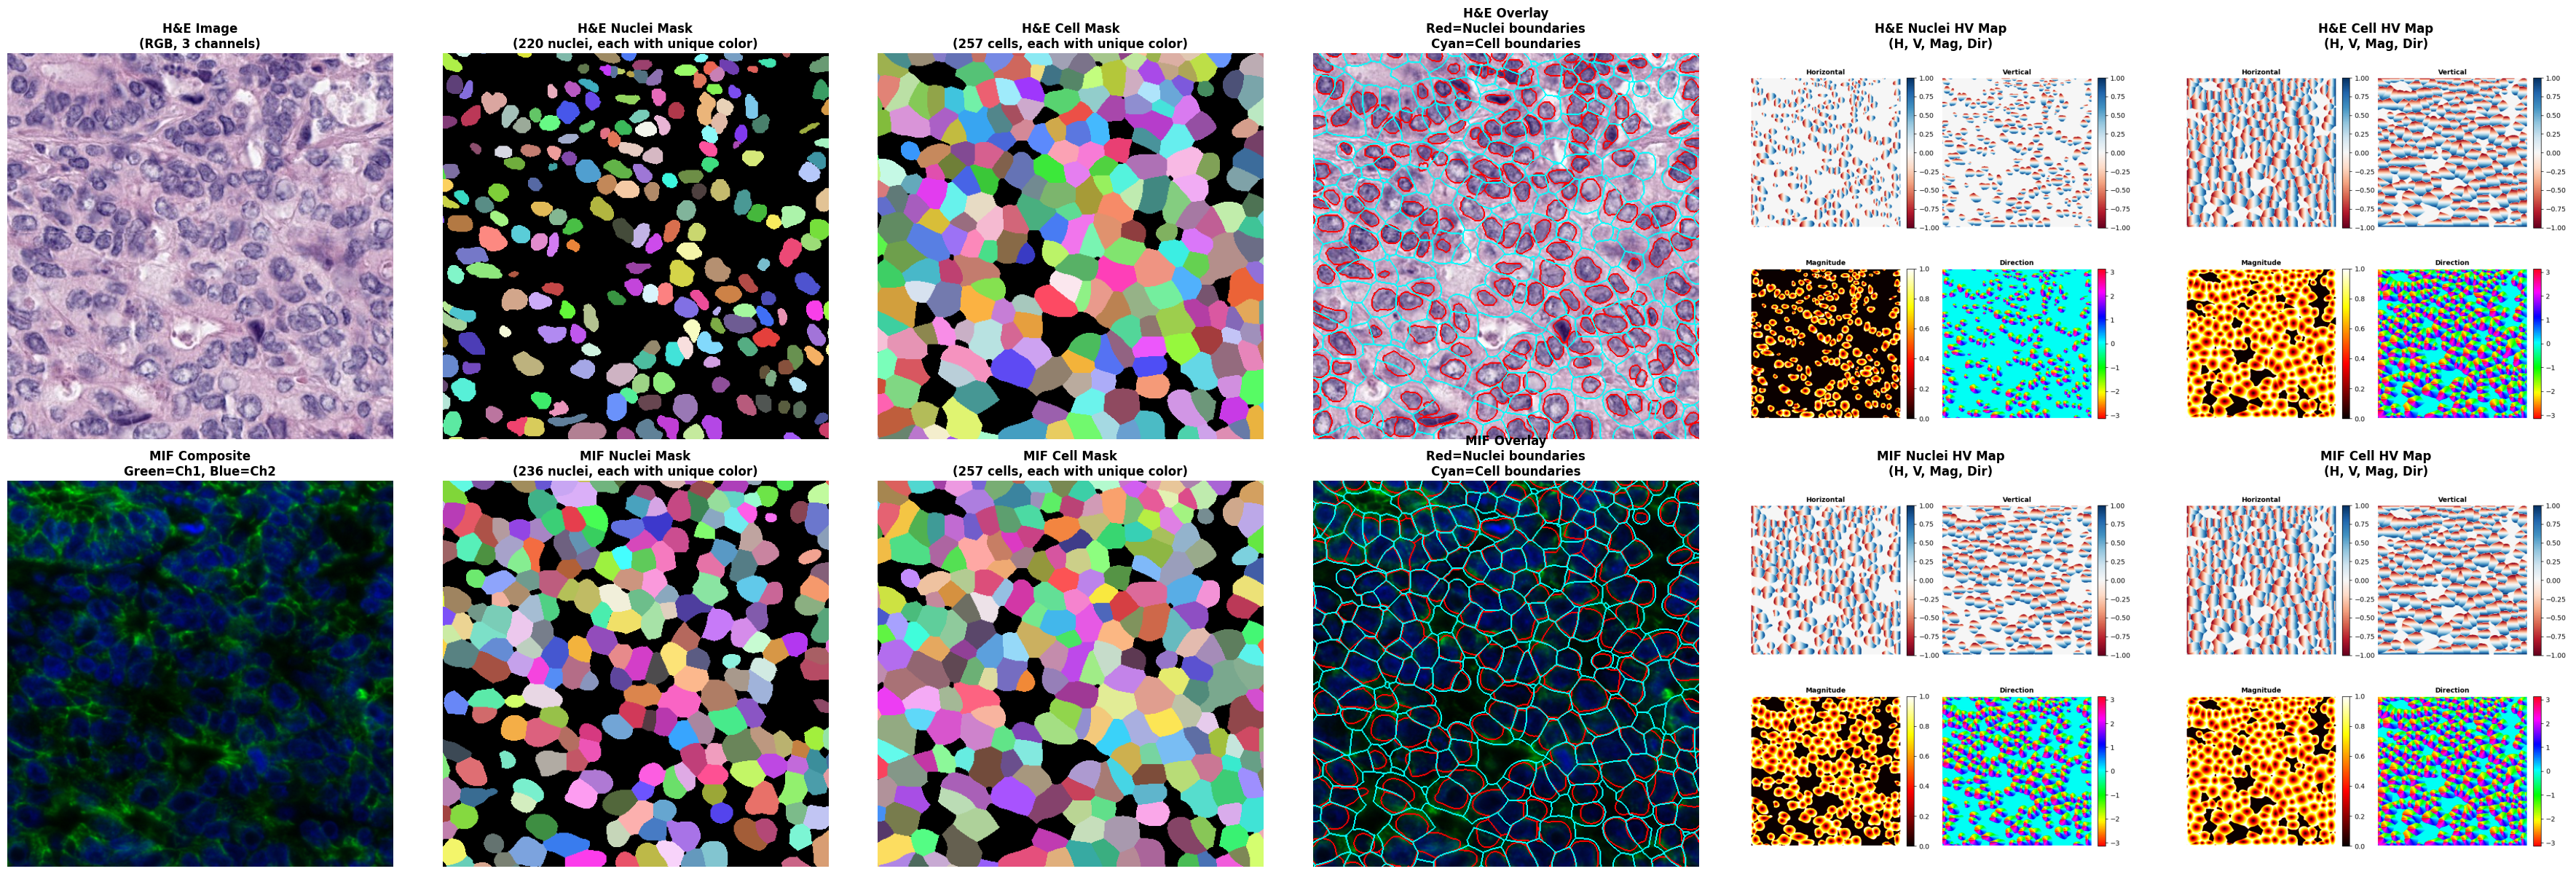


📊 Sample Statistics:
  H&E nuclei: 220, cells: 257
  MIF nuclei: 236, cells: 257

🔍 Data Range (before normalization):
  H&E range: [0.294118, 1.000000]
  MIF range: [0.000000, 1.000000]

🎨 HV Map Ranges:
  H&E Nuclei HV: [-1.000, 1.000]
  H&E Cell HV: [-1.000, 1.000]
  MIF Nuclei HV: [-1.000, 1.000]
  MIF Cell HV: [-1.000, 1.000]


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from skimage.segmentation import find_boundaries

def overlay_boundaries(image, mask, color='white'):
    """Overlay instance boundaries on image"""
    img_overlay = image.copy()
    if img_overlay.max() <= 1.0:
        img_overlay = (img_overlay * 255).astype(np.uint8)
    boundaries = find_boundaries(mask, mode='thick')
    
    if color == 'white':
        img_overlay[boundaries] = [255, 255, 255]
    elif color == 'red':
        img_overlay[boundaries] = [255, 0, 0]
    elif color == 'cyan':
        img_overlay[boundaries] = [0, 255, 255]
    
    return img_overlay

def colorize_instances(mask, seed=42):
    """Create RGB image with distinct random color for each instance"""
    colored = np.zeros((*mask.shape, 3), dtype=np.uint8)
    unique_ids = np.unique(mask)
    np.random.seed(seed)
    
    for instance_id in unique_ids:
        if instance_id == 0:
            continue
        color = (np.random.rand(3) * 200 + 55).astype(np.uint8)
        colored[mask == instance_id] = color
    
    return colored

def normalize_for_display(img):
    """Normalize image to 0-1 range based on actual min/max"""
    img = img.astype(np.float32)
    img_min = img.min()
    img_max = img.max()
    
    if img_max - img_min < 1e-10:
        return np.zeros_like(img)
    
    img_normalized = (img - img_min) / (img_max - img_min)
    return np.clip(img_normalized, 0, 1)

def create_hv_combined_visualization(hv_map):
    """
    Create a combined 2x2 visualization of HV map components
    
    Args:
        hv_map: (2, H, W) array with horizontal and vertical gradients
    
    Returns:
        Combined image for display
    """
    import matplotlib.pyplot as plt
    from matplotlib.backends.backend_agg import FigureCanvasAgg
    
    h_grad = hv_map[0]  # Horizontal gradient (-1 to 1)
    v_grad = hv_map[1]  # Vertical gradient (-1 to 1)
    
    # Calculate magnitude and angle
    magnitude = np.sqrt(h_grad**2 + v_grad**2)
    angle = np.arctan2(v_grad, h_grad)
    
    # Create figure with 2x2 subplots
    fig, axes = plt.subplots(2, 2, figsize=(8, 8))
    
    # Top-left: Horizontal component
    im0 = axes[0, 0].imshow(h_grad, cmap='RdBu', vmin=-1, vmax=1)
    axes[0, 0].set_title('Horizontal', fontsize=10, fontweight='bold')
    axes[0, 0].axis('off')
    plt.colorbar(im0, ax=axes[0, 0], fraction=0.046, pad=0.04)
    
    # Top-right: Vertical component
    im1 = axes[0, 1].imshow(v_grad, cmap='RdBu', vmin=-1, vmax=1)
    axes[0, 1].set_title('Vertical', fontsize=10, fontweight='bold')
    axes[0, 1].axis('off')
    plt.colorbar(im1, ax=axes[0, 1], fraction=0.046, pad=0.04)
    
    # Bottom-left: Magnitude
    im2 = axes[1, 0].imshow(magnitude, cmap='hot', vmin=0, vmax=1)
    axes[1, 0].set_title('Magnitude', fontsize=10, fontweight='bold')
    axes[1, 0].axis('off')
    plt.colorbar(im2, ax=axes[1, 0], fraction=0.046, pad=0.04)
    
    # Bottom-right: Direction
    im3 = axes[1, 1].imshow(angle, cmap='hsv', vmin=-np.pi, vmax=np.pi)
    axes[1, 1].set_title('Direction', fontsize=10, fontweight='bold')
    axes[1, 1].axis('off')
    plt.colorbar(im3, ax=axes[1, 1], fraction=0.046, pad=0.04)
    
    plt.tight_layout(pad=0.5)
    
    # Convert figure to image array
    canvas = FigureCanvasAgg(fig)
    canvas.draw()
    img_array = np.frombuffer(canvas.tostring_rgb(), dtype=np.uint8)
    img_array = img_array.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    
    plt.close(fig)
    
    return img_array

# Get one batch
batch = next(iter(train_loader))
sample_idx = 0

fig, axes = plt.subplots(2, 6, figsize=(36, 12))

# ============================================================================
# ROW 1: H&E
# ============================================================================

# H&E Image - NORMALIZED FOR DISPLAY
he_img = batch['he_image'][sample_idx].permute(1,2,0).cpu().numpy()
he_img = normalize_for_display(he_img)
axes[0, 0].imshow(he_img)
axes[0, 0].set_title('H&E Image\n(RGB, 3 channels)', fontsize=12, fontweight='bold')
axes[0, 0].axis('off')

# H&E Nuclei Colored Instances
he_nuclei_colored = colorize_instances(batch['he_nuclei_instance'][sample_idx].cpu().numpy(), seed=42)
n_nuclei = len(torch.unique(batch['he_nuclei_instance'][sample_idx])) - 1
axes[0, 1].imshow(he_nuclei_colored)
axes[0, 1].set_title(f'H&E Nuclei Mask\n({n_nuclei} nuclei, each with unique color)', 
                     fontsize=12, fontweight='bold')
axes[0, 1].axis('off')

# H&E Cell Colored Instances
he_cell_colored = colorize_instances(batch['he_cell_instance'][sample_idx].cpu().numpy(), seed=123)
n_cells = len(torch.unique(batch['he_cell_instance'][sample_idx])) - 1
axes[0, 2].imshow(he_cell_colored)
axes[0, 2].set_title(f'H&E Cell Mask\n({n_cells} cells, each with unique color)', 
                     fontsize=12, fontweight='bold')
axes[0, 2].axis('off')

# H&E Overlay with boundaries
he_img_uint8 = (he_img * 255).astype(np.uint8)
he_overlay = overlay_boundaries(he_img_uint8, batch['he_nuclei_instance'][sample_idx].cpu().numpy(), color='red')
he_overlay = overlay_boundaries(he_overlay, batch['he_cell_instance'][sample_idx].cpu().numpy(), color='cyan')
axes[0, 3].imshow(he_overlay)
axes[0, 3].set_title('H&E Overlay\nRed=Nuclei boundaries\nCyan=Cell boundaries', 
                     fontsize=12, fontweight='bold')
axes[0, 3].axis('off')

# H&E Nuclei HV Map
he_nuclei_hv = batch['he_nuclei_hv'][sample_idx].cpu().numpy()
he_nuclei_hv_vis = create_hv_combined_visualization(he_nuclei_hv)
axes[0, 4].imshow(he_nuclei_hv_vis)
axes[0, 4].set_title('H&E Nuclei HV Map\n(H, V, Mag, Dir)', 
                     fontsize=12, fontweight='bold')
axes[0, 4].axis('off')

# H&E Cell HV Map
he_cell_hv = batch['he_cell_hv'][sample_idx].cpu().numpy()
he_cell_hv_vis = create_hv_combined_visualization(he_cell_hv)
axes[0, 5].imshow(he_cell_hv_vis)
axes[0, 5].set_title('H&E Cell HV Map\n(H, V, Mag, Dir)', 
                     fontsize=12, fontweight='bold')
axes[0, 5].axis('off')

# ============================================================================
# ROW 2: MIF
# ============================================================================

# MIF Composite - NORMALIZED FOR DISPLAY
mif_img = batch['mif_image'][sample_idx].cpu().numpy()
mif_vis = np.zeros((mif_img.shape[1], mif_img.shape[2], 3))
mif_ch0 = normalize_for_display(mif_img[0])
mif_ch1 = normalize_for_display(mif_img[1])
mif_vis[:, :, 1] = mif_ch0  # Green
mif_vis[:, :, 2] = mif_ch1  # Blue
axes[1, 0].imshow(mif_vis)
axes[1, 0].set_title('MIF Composite\nGreen=Ch1, Blue=Ch2', 
                     fontsize=12, fontweight='bold')
axes[1, 0].axis('off')

# MIF Nuclei Colored Instances
mif_nuclei_colored = colorize_instances(batch['mif_nuclei_instance'][sample_idx].cpu().numpy(), seed=456)
n_mif_nuclei = len(torch.unique(batch['mif_nuclei_instance'][sample_idx])) - 1
axes[1, 1].imshow(mif_nuclei_colored)
axes[1, 1].set_title(f'MIF Nuclei Mask\n({n_mif_nuclei} nuclei, each with unique color)', 
                     fontsize=12, fontweight='bold')
axes[1, 1].axis('off')

# MIF Cell Colored Instances
mif_cell_colored = colorize_instances(batch['mif_cell_instance'][sample_idx].cpu().numpy(), seed=789)
n_mif_cells = len(torch.unique(batch['mif_cell_instance'][sample_idx])) - 1
axes[1, 2].imshow(mif_cell_colored)
axes[1, 2].set_title(f'MIF Cell Mask\n({n_mif_cells} cells, each with unique color)', 
                     fontsize=12, fontweight='bold')
axes[1, 2].axis('off')

# MIF Overlay with boundaries
mif_vis_uint8 = (mif_vis * 255).astype(np.uint8)
mif_overlay = overlay_boundaries(mif_vis_uint8, batch['mif_nuclei_instance'][sample_idx].cpu().numpy(), color='red')
mif_overlay = overlay_boundaries(mif_overlay, batch['mif_cell_instance'][sample_idx].cpu().numpy(), color='cyan')
axes[1, 3].imshow(mif_overlay)
axes[1, 3].set_title('MIF Overlay\nRed=Nuclei boundaries\nCyan=Cell boundaries', 
                     fontsize=12, fontweight='bold')
axes[1, 3].axis('off')

# MIF Nuclei HV Map
mif_nuclei_hv = batch['mif_nuclei_hv'][sample_idx].cpu().numpy()
mif_nuclei_hv_vis = create_hv_combined_visualization(mif_nuclei_hv)
axes[1, 4].imshow(mif_nuclei_hv_vis)
axes[1, 4].set_title('MIF Nuclei HV Map\n(H, V, Mag, Dir)', 
                     fontsize=12, fontweight='bold')
axes[1, 4].axis('off')

# MIF Cell HV Map
mif_cell_hv = batch['mif_cell_hv'][sample_idx].cpu().numpy()
mif_cell_hv_vis = create_hv_combined_visualization(mif_cell_hv)
axes[1, 5].imshow(mif_cell_hv_vis)
axes[1, 5].set_title('MIF Cell HV Map\n(H, V, Mag, Dir)', 
                     fontsize=12, fontweight='bold')
axes[1, 5].axis('off')

plt.tight_layout()
plt.savefig('batch_verification_with_hv.png', dpi=150, bbox_inches='tight')
print("✅ Saved to batch_verification_with_hv.png")
plt.show()

# Print stats
print(f"\n📊 Sample Statistics:")
print(f"  H&E nuclei: {n_nuclei}, cells: {n_cells}")
print(f"  MIF nuclei: {n_mif_nuclei}, cells: {n_mif_cells}")
print(f"\n🔍 Data Range (before normalization):")
print(f"  H&E range: [{batch['he_image'][sample_idx].min():.6f}, {batch['he_image'][sample_idx].max():.6f}]")
print(f"  MIF range: [{batch['mif_image'][sample_idx].min():.6f}, {batch['mif_image'][sample_idx].max():.6f}]")
print(f"\n🎨 HV Map Ranges:")
print(f"  H&E Nuclei HV: [{he_nuclei_hv.min():.3f}, {he_nuclei_hv.max():.3f}]")
print(f"  H&E Cell HV: [{he_cell_hv.min():.3f}, {he_cell_hv.max():.3f}]")
print(f"  MIF Nuclei HV: [{mif_nuclei_hv.min():.3f}, {mif_nuclei_hv.max():.3f}]")
print(f"  MIF Cell HV: [{mif_cell_hv.min():.3f}, {mif_cell_hv.max():.3f}]")

## Data analysis

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.models as models
from tqdm import tqdm
import torch.optim as optim
import random
import numpy as np

class DiceFocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, smooth=1):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.smooth = smooth
    
    def forward(self, pred, target):
        pred_flat = pred.view(-1)
        target_flat = target.view(-1)
        intersection = (pred_flat * target_flat).sum()
        dice_loss = 1 - (2 * intersection + self.smooth) / (pred_flat.sum() + target_flat.sum() + self.smooth)
        
        ce_loss = F.binary_cross_entropy(pred, target, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        focal_loss = focal_loss.mean()
        
        return dice_loss + focal_loss

class MSGELossMaps(nn.Module):
    def __init__(self):
        super().__init__()

    def get_sobel_kernel(self, size: int, device: str):
        assert size % 2 == 1, "Must be odd, get size=%d" % size

        h_range = torch.arange(
            -size // 2 + 1,
            size // 2 + 1,
            dtype=torch.float32,
            device=device,
            requires_grad=False,
        )
        v_range = torch.arange(
            -size // 2 + 1,
            size // 2 + 1,
            dtype=torch.float32,
            device=device,
            requires_grad=False,
        )
        h, v = torch.meshgrid(h_range, v_range, indexing="ij")
        kernel_h = h / (h * h + v * v + 1.0e-15)
        kernel_v = v / (h * h + v * v + 1.0e-15)
        return kernel_h, kernel_v

    def get_gradient_hv(self, hv: torch.Tensor, device: str):
        kernel_h, kernel_v = self.get_sobel_kernel(5, device=device)
        kernel_h = kernel_h.view(1, 1, 5, 5)
        kernel_v = kernel_v.view(1, 1, 5, 5)

        h_ch = hv[..., 0].unsqueeze(1)
        v_ch = hv[..., 1].unsqueeze(1)

        h_dh_ch = F.conv2d(h_ch, kernel_h, padding=2)
        v_dv_ch = F.conv2d(v_ch, kernel_v, padding=2)
        dhv = torch.cat([h_dh_ch, v_dv_ch], dim=1)
        dhv = dhv.permute(0, 2, 3, 1).contiguous()
        return dhv

    def forward(self, input: torch.Tensor, target: torch.Tensor, focus: torch.Tensor, device: str):
        input = input.permute(0, 2, 3, 1)
        target = target.permute(0, 2, 3, 1)
        focus = focus.permute(0, 2, 3, 1)
        focus = focus[..., 0]

        focus = (focus[..., None]).float()
        focus = torch.cat([focus, focus], axis=-1).to(device)
        true_grad = self.get_gradient_hv(target, device)
        pred_grad = self.get_gradient_hv(input, device)
        loss = pred_grad - true_grad
        loss = focus * (loss * loss)
        loss = loss.sum() / (focus.sum() + 1.0e-8)
        return loss

class MultiModalPathologyUNet(nn.Module):
    """
    Multi-modal UNet for H&E + MIF pathology images
    
    Input: 5 channels (3 H&E + 2 MIF)
    Output: 
        - 4 segmentation masks (HE nuclei, HE cells, MIF nuclei, MIF cells)
        - 4 HV maps (corresponding to each mask type)
    """
    def __init__(self, backbone='resnet50', pretrained=True, dropout_rate=0.3):
        super().__init__()
        
        if backbone == 'resnet34':
            resnet = models.resnet34(weights='IMAGENET1K_V1' if pretrained else None)
            channels = [64, 64, 128, 256, 512]
        elif backbone == 'resnet50':
            resnet = models.resnet50(weights='IMAGENET1K_V1' if pretrained else None)
            channels = [64, 256, 512, 1024, 2048]
        elif backbone == 'resnet101':
            resnet = models.resnet101(weights='IMAGENET1K_V1' if pretrained else None)
            channels = [64, 256, 512, 1024, 2048]
        else:
            raise ValueError(f"Unsupported backbone: {backbone}")
        
        # Modify first conv layer to accept 5 channels (3 H&E + 2 MIF)
        original_conv1 = resnet.conv1
        self.conv1 = nn.Conv2d(5, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Initialize new conv1 with pretrained weights for first 3 channels
        with torch.no_grad():
            self.conv1.weight[:, :3, :, :] = original_conv1.weight
            # Initialize MIF channels with average of RGB weights
            self.conv1.weight[:, 3:, :, :] = original_conv1.weight.mean(dim=1, keepdim=True).repeat(1, 2, 1, 1)
        
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4
        
        self.channels = channels
        self.dropout_rate = dropout_rate
        
        # Dropout layers
        self.dropout_high = nn.Dropout2d(dropout_rate * 1.5)
        self.dropout_mid = nn.Dropout2d(dropout_rate)
        
        # ========== HE NUCLEI DECODER ==========
        self.up4_he_nuclei = nn.ConvTranspose2d(channels[4], channels[3], 2, stride=2)
        self.dec4_he_nuclei = self.conv_block_improved(channels[4], channels[3], dropout_rate * 1.2)
        self.up3_he_nuclei = nn.ConvTranspose2d(channels[3], channels[2], 2, stride=2)
        self.dec3_he_nuclei = self.conv_block_improved(channels[3], channels[2], dropout_rate)
        self.up2_he_nuclei = nn.ConvTranspose2d(channels[2], channels[1], 2, stride=2)
        self.dec2_he_nuclei = self.conv_block_improved(channels[2], channels[1], dropout_rate * 0.8)
        self.up1_he_nuclei = nn.ConvTranspose2d(channels[1], 64, 2, stride=2)
        self.dec1_he_nuclei = self.conv_block_improved(128, 64, dropout_rate * 0.5)
        self.up0_he_nuclei = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.dec0_he_nuclei = self.conv_block_improved(32, 32, dropout_rate * 0.3)
        self.final_he_nuclei_seg = nn.Conv2d(32, 1, 1)
        self.final_he_nuclei_hv = nn.Conv2d(32, 2, 1)
        
        # ========== HE CELL DECODER ==========
        self.up4_he_cell = nn.ConvTranspose2d(channels[4], channels[3], 2, stride=2)
        self.dec4_he_cell = self.conv_block_improved(channels[4], channels[3], dropout_rate * 1.2)
        self.up3_he_cell = nn.ConvTranspose2d(channels[3], channels[2], 2, stride=2)
        self.dec3_he_cell = self.conv_block_improved(channels[3], channels[2], dropout_rate)
        self.up2_he_cell = nn.ConvTranspose2d(channels[2], channels[1], 2, stride=2)
        self.dec2_he_cell = self.conv_block_improved(channels[2], channels[1], dropout_rate * 0.8)
        self.up1_he_cell = nn.ConvTranspose2d(channels[1], 64, 2, stride=2)
        self.dec1_he_cell = self.conv_block_improved(128, 64, dropout_rate * 0.5)
        self.up0_he_cell = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.dec0_he_cell = self.conv_block_improved(32, 32, dropout_rate * 0.3)
        self.final_he_cell_seg = nn.Conv2d(32, 1, 1)
        self.final_he_cell_hv = nn.Conv2d(32, 2, 1)
        
        # ========== MIF NUCLEI DECODER ==========
        self.up4_mif_nuclei = nn.ConvTranspose2d(channels[4], channels[3], 2, stride=2)
        self.dec4_mif_nuclei = self.conv_block_improved(channels[4], channels[3], dropout_rate * 1.2)
        self.up3_mif_nuclei = nn.ConvTranspose2d(channels[3], channels[2], 2, stride=2)
        self.dec3_mif_nuclei = self.conv_block_improved(channels[3], channels[2], dropout_rate)
        self.up2_mif_nuclei = nn.ConvTranspose2d(channels[2], channels[1], 2, stride=2)
        self.dec2_mif_nuclei = self.conv_block_improved(channels[2], channels[1], dropout_rate * 0.8)
        self.up1_mif_nuclei = nn.ConvTranspose2d(channels[1], 64, 2, stride=2)
        self.dec1_mif_nuclei = self.conv_block_improved(128, 64, dropout_rate * 0.5)
        self.up0_mif_nuclei = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.dec0_mif_nuclei = self.conv_block_improved(32, 32, dropout_rate * 0.3)
        self.final_mif_nuclei_seg = nn.Conv2d(32, 1, 1)
        self.final_mif_nuclei_hv = nn.Conv2d(32, 2, 1)
        
        # ========== MIF CELL DECODER ==========
        self.up4_mif_cell = nn.ConvTranspose2d(channels[4], channels[3], 2, stride=2)
        self.dec4_mif_cell = self.conv_block_improved(channels[4], channels[3], dropout_rate * 1.2)
        self.up3_mif_cell = nn.ConvTranspose2d(channels[3], channels[2], 2, stride=2)
        self.dec3_mif_cell = self.conv_block_improved(channels[3], channels[2], dropout_rate)
        self.up2_mif_cell = nn.ConvTranspose2d(channels[2], channels[1], 2, stride=2)
        self.dec2_mif_cell = self.conv_block_improved(channels[2], channels[1], dropout_rate * 0.8)
        self.up1_mif_cell = nn.ConvTranspose2d(channels[1], 64, 2, stride=2)
        self.dec1_mif_cell = self.conv_block_improved(128, 64, dropout_rate * 0.5)
        self.up0_mif_cell = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.dec0_mif_cell = self.conv_block_improved(32, 32, dropout_rate * 0.3)
        self.final_mif_cell_seg = nn.Conv2d(32, 1, 1)
        self.final_mif_cell_hv = nn.Conv2d(32, 2, 1)
        
    def conv_block_improved(self, in_ch, out_ch, dropout_rate=0.0):
        """Improved conv block with dropout"""
        layers = [
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        ]
        
        if dropout_rate > 0:
            layers.append(nn.Dropout2d(dropout_rate))
            
        layers.extend([
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        ])
        
        return nn.Sequential(*layers)
    
    def decode_branch(self, x4, x3, x2, x1, x0, branch_name):
        """Generic decoder branch"""
        # Get branch-specific layers
        up4 = getattr(self, f'up4_{branch_name}')
        dec4 = getattr(self, f'dec4_{branch_name}')
        up3 = getattr(self, f'up3_{branch_name}')
        dec3 = getattr(self, f'dec3_{branch_name}')
        up2 = getattr(self, f'up2_{branch_name}')
        dec2 = getattr(self, f'dec2_{branch_name}')
        up1 = getattr(self, f'up1_{branch_name}')
        dec1 = getattr(self, f'dec1_{branch_name}')
        up0 = getattr(self, f'up0_{branch_name}')
        dec0 = getattr(self, f'dec0_{branch_name}')
        final_seg = getattr(self, f'final_{branch_name}_seg')
        final_hv = getattr(self, f'final_{branch_name}_hv')
        
        # Decoder path
        d4 = dec4(torch.cat([up4(x4), x3], dim=1))
        d3 = dec3(torch.cat([up3(d4), x2], dim=1))
        d2 = dec2(torch.cat([up2(d3), x1], dim=1))
        d1 = dec1(torch.cat([up1(d2), x0], dim=1))
        d0 = dec0(up0(d1))
        
        # Outputs
        seg_out = torch.sigmoid(final_seg(d0))
        hv_out = torch.tanh(final_hv(d0))
        
        return seg_out, hv_out
    
    def forward(self, x):
        # Shared encoder
        x0 = self.relu(self.bn1(self.conv1(x)))  # Input is 5 channels
        x0_pool = self.maxpool(x0)
        
        x1 = self.layer1(x0_pool)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        
        if self.training:
            x3 = self.dropout_mid(x3)
        
        x4 = self.layer4(x3)
        
        if self.training:
            x4 = self.dropout_high(x4)
        
        # Four separate decoder branches
        he_nuclei_seg, he_nuclei_hv = self.decode_branch(x4, x3, x2, x1, x0, 'he_nuclei')
        he_cell_seg, he_cell_hv = self.decode_branch(x4, x3, x2, x1, x0, 'he_cell')
        mif_nuclei_seg, mif_nuclei_hv = self.decode_branch(x4, x3, x2, x1, x0, 'mif_nuclei')
        mif_cell_seg, mif_cell_hv = self.decode_branch(x4, x3, x2, x1, x0, 'mif_cell')
        
        return {
            'he_nuclei_seg': he_nuclei_seg,
            'he_nuclei_hv': he_nuclei_hv,
            'he_cell_seg': he_cell_seg,
            'he_cell_hv': he_cell_hv,
            'mif_nuclei_seg': mif_nuclei_seg,
            'mif_nuclei_hv': mif_nuclei_hv,
            'mif_cell_seg': mif_cell_seg,
            'mif_cell_hv': mif_cell_hv,
        }

def set_seed(seed=42):
    """Set random seeds for reproducibility"""
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def train_model(model, train_loader, val_loader, num_epochs=50, lr=1e-3, weight_decay=1e-4):
    import os
    os.makedirs('checkpoints', exist_ok=True)
    
    set_seed(42)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    seg_criterion = DiceFocalLoss(alpha=1, gamma=2)
    hv_criterion = MSGELossMaps()
    
    # Parameter grouping
    backbone_params = []
    decoder_params = []
    bn_params = []
    
    for name, param in model.named_parameters():
        if 'bn' in name or 'norm' in name:
            bn_params.append(param)
        elif any(x in name for x in ['conv1', 'bn1', 'layer1', 'layer2', 'layer3', 'layer4']):
            backbone_params.append(param)
        else:
            decoder_params.append(param)
    
    optimizer = optim.AdamW([
        {'params': backbone_params, 'lr': lr * 0.1, 'weight_decay': weight_decay * 0.5},
        {'params': decoder_params, 'lr': lr, 'weight_decay': weight_decay},
        {'params': bn_params, 'lr': lr, 'weight_decay': 0.0}
    ])
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.8, patience=5, verbose=True, min_lr=1e-7
    )
    
    best_val_loss = float('inf')
    patience_counter = 0
    max_patience = 15
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        
        for batch_idx, batch in enumerate(train_pbar):
            # Input: combined 5-channel image
            img = batch['image'].to(device)
            
            # Ground truth masks and HV maps
            he_nuclei_mask = batch['he_nuclei_mask'].float().unsqueeze(1).to(device)
            he_cell_mask = batch['he_cell_mask'].float().unsqueeze(1).to(device)
            mif_nuclei_mask = batch['mif_nuclei_mask'].float().unsqueeze(1).to(device)
            mif_cell_mask = batch['mif_cell_mask'].float().unsqueeze(1).to(device)
            
            he_nuclei_hv = batch['he_nuclei_hv'].to(device)
            he_cell_hv = batch['he_cell_hv'].to(device)
            mif_nuclei_hv = batch['mif_nuclei_hv'].to(device)
            mif_cell_hv = batch['mif_cell_hv'].to(device)
            
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(img)
            
            # Compute losses for each branch
            loss_he_nuclei_seg = seg_criterion(outputs['he_nuclei_seg'], he_nuclei_mask)
            loss_he_nuclei_hv = hv_criterion(outputs['he_nuclei_hv'], he_nuclei_hv, he_nuclei_mask, device)
            
            loss_he_cell_seg = seg_criterion(outputs['he_cell_seg'], he_cell_mask)
            loss_he_cell_hv = hv_criterion(outputs['he_cell_hv'], he_cell_hv, he_cell_mask, device)
            
            loss_mif_nuclei_seg = seg_criterion(outputs['mif_nuclei_seg'], mif_nuclei_mask)
            loss_mif_nuclei_hv = hv_criterion(outputs['mif_nuclei_hv'], mif_nuclei_hv, mif_nuclei_mask, device)
            
            loss_mif_cell_seg = seg_criterion(outputs['mif_cell_seg'], mif_cell_mask)
            loss_mif_cell_hv = hv_criterion(outputs['mif_cell_hv'], mif_cell_hv, mif_cell_mask, device)
            
            # Total loss
            total_loss = (loss_he_nuclei_seg + 0.6 * loss_he_nuclei_hv +
                         loss_he_cell_seg + 0.6 * loss_he_cell_hv +
                         loss_mif_nuclei_seg + 0.6 * loss_mif_nuclei_hv +
                         loss_mif_cell_seg + 0.6 * loss_mif_cell_hv) / 4.0
            
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            optimizer.step()
            
            train_loss += total_loss.item()
            train_pbar.set_postfix({'loss': f'{total_loss.item():.4f}'})
        
        # Validation
        model.eval()
        val_loss = 0
        val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')
        
        with torch.no_grad():
            for batch in val_pbar:
                img = batch['image'].to(device)
                
                he_nuclei_mask = batch['he_nuclei_mask'].float().unsqueeze(1).to(device)
                he_cell_mask = batch['he_cell_mask'].float().unsqueeze(1).to(device)
                mif_nuclei_mask = batch['mif_nuclei_mask'].float().unsqueeze(1).to(device)
                mif_cell_mask = batch['mif_cell_mask'].float().unsqueeze(1).to(device)
                
                he_nuclei_hv = batch['he_nuclei_hv'].to(device)
                he_cell_hv = batch['he_cell_hv'].to(device)
                mif_nuclei_hv = batch['mif_nuclei_hv'].to(device)
                mif_cell_hv = batch['mif_cell_hv'].to(device)
                
                outputs = model(img)
                
                loss_he_nuclei_seg = seg_criterion(outputs['he_nuclei_seg'], he_nuclei_mask)
                loss_he_nuclei_hv = hv_criterion(outputs['he_nuclei_hv'], he_nuclei_hv, he_nuclei_mask, device)
                
                loss_he_cell_seg = seg_criterion(outputs['he_cell_seg'], he_cell_mask)
                loss_he_cell_hv = hv_criterion(outputs['he_cell_hv'], he_cell_hv, he_cell_mask, device)
                
                loss_mif_nuclei_seg = seg_criterion(outputs['mif_nuclei_seg'], mif_nuclei_mask)
                loss_mif_nuclei_hv = hv_criterion(outputs['mif_nuclei_hv'], mif_nuclei_hv, mif_nuclei_mask, device)
                
                loss_mif_cell_seg = seg_criterion(outputs['mif_cell_seg'], mif_cell_mask)
                loss_mif_cell_hv = hv_criterion(outputs['mif_cell_hv'], mif_cell_hv, mif_cell_mask, device)
                
                total_loss = (loss_he_nuclei_seg + 0.6 * loss_he_nuclei_hv +
                             loss_he_cell_seg + 0.6 * loss_he_cell_hv +
                             loss_mif_nuclei_seg + 0.6 * loss_mif_nuclei_hv +
                             loss_mif_cell_seg + 0.6 * loss_mif_cell_hv) / 4.0
                
                val_loss += total_loss.item()
                val_pbar.set_postfix({'loss': f'{total_loss.item():.4f}'})
        
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        
        print(f'\nEpoch {epoch+1}: Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}')
        
        scheduler.step(val_loss)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
            }, 'checkpoints/best_multimodal_model.pth')
            print(f'💾 Best model saved! Val loss: {val_loss:.4f}')
        else:
            patience_counter += 1
            
        if patience_counter >= max_patience:
            print(f'Early stopping after {epoch+1} epochs')
            break
    
    return model

# Create model
model = MultiModalPathologyUNet(backbone='resnet34', pretrained=True, dropout_rate=0.3)

# Print model info
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Total parameters: 33,958,860
Trainable parameters: 33,958,860


## Tranier

In [8]:
# Train the model
trained_model = train_model(model, train_loader, val_loader, num_epochs=25, lr=1e-3)
print("✅ Training completed!")

Epoch 1/25 [Train]:   0%|          | 0/496 [00:05<?, ?it/s]


RuntimeError: DataLoader worker (pid(s) 19905, 19968, 20031, 20094) exited unexpectedly